**University:** NOVA Information Management School<br/>
**Program:** Master’s Degree Program in Data Science and Advanced Analytics<br/>
**Academic Year:** 2022/2023

```
============== Students: ==============
Iryna Savchuk (m20211310@novaims.unl.pt)
Cátia Sofia Pereira Parrinha (m20201320@novaims.unl.pt)
Giulia Bovenga (m20221637@novaims.unl.pt)
Hubert Oberhauser (m20220628@novaims.unl.pt)
Leo Allgaier (m20220635@novaims.unl.pt)
=======================================
```

**Data Source**
*   Clean data to perform model training can be downloaded from here: [datasets.zip](https://drive.google.com/file/d/1xMF-lupg9UX-UZUD6NlC2h-Ao08gQ6f3/view?usp=sharing) <br>
This dataset was saved in google drive in the following path: "/content/gdrive/MyDrive/DL_Project/"


------------------------------
**Summary**

This notebook contains the different architectures explored from different parameters developed through sequential and functional construction.
The main [outcomes](#scrollTo=196mBvAPo_p1&line=5&uniqifier=1) are summed up in the last section of the current notebook.

------------------------------

# Import packages

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, Model, layers, initializers, regularizers, optimizers, metrics 

import os
import time
import shutil
import random 
import zipfile

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

Import the datasets.zip file stored in "/content/gdrive/MyDrive/DL_Project/"

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Set the machine
gdrive = True
# Set the connection string
path = "/content/gdrive/MyDrive/DL_Project/"
main_folder, training_folder, validation_folder, testing_folder = "datasets/", "train/", "validation/", "test/"
# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/gdrive')        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'datasets.zip', 'datasets.zip')
    # Extract files
    zip_ = zipfile.ZipFile('datasets.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = "/content/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
File transfer completed in 1.109 seconds


# List of parameters

The first parameters regarding our images:
* Resize the image from 500 to 128.
* As all images have the same shape, we do not need to crop them. <br>
* We will work with color images. <br>
* Batch size of 64, the number of batches that will be loaded iteration after an iteration that will train the gradient descent. <br>
* As a multi-class classification model that will return three different classes, the label_mode must be categorical. <br>
* Randomization of the order of the instances set as true ensures that each minibatch represents the whole set of classes. <br>
* We do not need to use validation_split; our original dataset already has this split.


In [4]:
image_size=(128, 128)  
crop_to_aspect_ratio=False 
color_mode='rgb'  
batch_size=64  
label_mode="categorical"  
shuffle=True  
seed=0  

# Create train, validation and test datasets

In [5]:
# Generate an object of type tf.data.Dataset 
ds_train = image_dataset_from_directory(path + main_folder + training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                shuffle=shuffle,
                                                seed=seed)

ds_validation = image_dataset_from_directory(path + main_folder + validation_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                shuffle=shuffle,
                                                seed=seed)

ds_test = image_dataset_from_directory(path + main_folder + testing_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                shuffle=shuffle,
                                                seed=seed)

# Check object properties
print("\nObject's type:\t", type(ds_train))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_train, tf.data.Dataset))
print("Classes:", ds_train.class_names)

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['angular_leaf_spot', 'bean_rust', 'healthy']


We can check 
* The [Batch Size, Height, Width, Color depth], from the first image, the first two pixels, of the first channel. <br>
* The first five values from the vector. <br>
* and the balance of our target.


In [6]:
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()
print(batch_x_train.shape, batch_y_train.shape)
print("\nSample of x_train:", batch_x_train[0, 0:2, 0:2, 0])  
print("\nSample of y_train:", batch_y_train[0:5])  
print("Sample average of y_train:", tf.reduce_mean(batch_y_train))  

(64, 128, 128, 3) (64, 3)

Sample of x_train: tf.Tensor(
[[ 99.26709   99.308105]
 [107.84375  138.55054 ]], shape=(2, 2), dtype=float32)

Sample of y_train: tf.Tensor(
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]], shape=(5, 3), dtype=float32)
Sample average of y_train: tf.Tensor(0.33333334, shape=(), dtype=float32)


We have a batch of 64 color images of a size 128x128, stored in rank-3 tensor.
We verify that our target is balanced with 33% for each one of the three classes.

# Augmentation

Since our dataset is small, Augmentation should improve the training data's quality and diversity, making the models more robust and prompt to generalize and avoid overfitting. <br>
We will generate more training data by a random transformation like flip, rotation, zoom, contrast, brightness, and translation.

In [7]:
augmentation = Sequential([layers.RandomFlip(), 
                           layers.RandomRotation(factor=0.2), 
                           layers.RandomZoom(height_factor=0.1, width_factor=0.1),
                           layers.RandomContrast(factor=0.3),
                           layers.RandomBrightness(factor=0.3),
                           layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))], 
                           name="my_augmentation_pipeline")

In [8]:
def show_augmented_sample_batch(batch_x, augmentation_pipe, trials=4, fig_size=(10, 6)):
    # Plot the images
    _, axs = plt.subplots(len(batch_x), trials + 1, figsize=(10, 6), layout='constrained')
    for i, img in enumerate(batch_x):
        axs[i, 0].imshow(tf.cast(img, tf.int32))
        axs[i, 0].set_title("Original image", size=8)
        for t in range(trials):
            # Pass through the augmentation pipeline
            augmented_i = augmentation_pipe(img, training=True)
            axs[i, t+1].imshow(tf.cast(augmented_i, tf.int32))
            axs[i, t+1].set_title("Transformed image#{}".format(t), size=8)

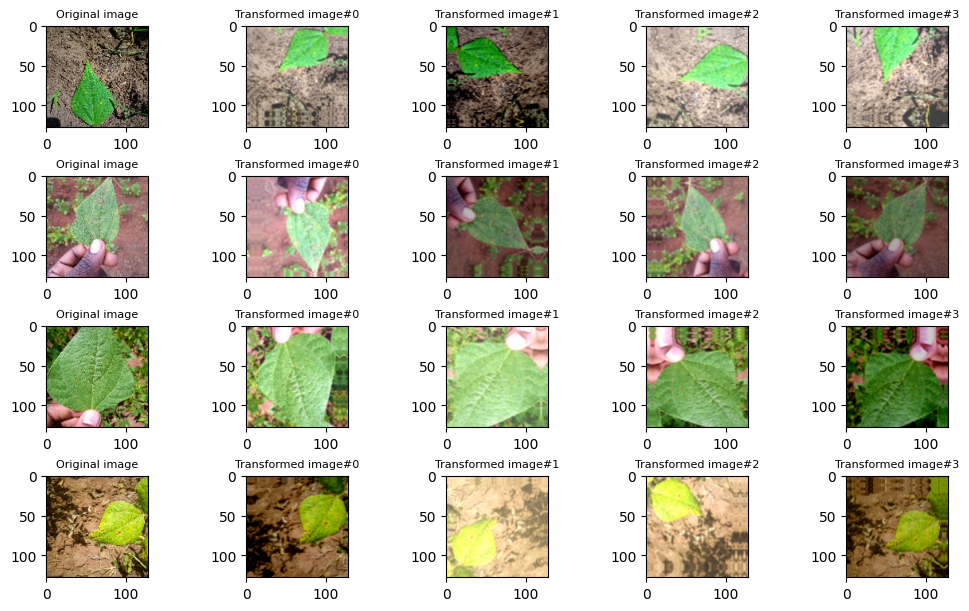

In [9]:
show_augmented_sample_batch(batch_x_train[0:4], augmentation_pipe=augmentation)

These are some examples from the previous transformation.

# Architectures

Set the input shape

In [10]:
input_shape = tuple(batch_x_train.shape)
input_shape

(64, 128, 128, 3)

## Sequencial API

Sequential API models, are a simple, straightforward approach for building linear models. Each layer in the model takes the output of the previous layer as input, and the output of the last layer is the final output of the model. This approach is suitable for building simple feedforward neural networks, but it can be limiting when designing more complex architectures.

## CNN 1 - LeNet

Our initial architecture is based on LeNet-5, which merged earlier concepts of convolutional neural networks and backpropagation to become the first successful application of neural networks.
The researchers suggested employing a LeNet-5 artificial neural network (ANN) comprising two components: a convolutional encoder comprising two convolutional layers and a dense block comprising three fully connected layers. The complete structure was trained through the backpropagation algorithm. <br>

**Architecture description** <br>



* In this architecture, we start setting the input image shape. <br>
* Then we apply a convolution layer(to learn local patterns), where set 18 (6x3) filters over the initial input, set the size of patches extracted from the inputs (5,5) (at the end, we also explore to (7,7) and (3,3)) and an initializer GlorotNormal. <br>
* We apply an activation function of softmax used to multi-class classification models. The 3-way softmax classification layer returns an array of 3 probability scores, summing up one. The probability belongs to one of the three classes. <br>
* The image becomes ready for the pooling step, providing our convolutional neural network the extraction of the maximum value to account for distortion, providing the faculty of spatial invariance. <br>
* with the output of the first layer, we repeat the process with the second layer, with 48 (16x3) filters over its input<br>
* Then we flatten to get a pooled featured map that will be the input for our ANN. <br>
* This way, we apply the classification through the dense layers (that learn global patterns in their input feature space) with three units, the dimensionality of our output space, with the softmax activation function. <br>


After the architecture design, we compile the model to get ready to train. We need to pick: <br>
* Loss Function - The model's ability to assess its performance on the training data enables it to guide itself toward the correct direction to attempt to minimize. We use categorical_crossentropy because the target variable  in one-hot encoded, a vector/matrix with binary where 1 represents the true class label <br>
* Optimizer - The process by which the model enhances its performance is through updating itself using the training data it encounters. How the gradient of the loss will be used to update parameters. we will start with the SGD(Stochastic Gradient Descent) with a learning rate of 0.001 <br>
* Metrics - to test the accuracy of the model, the fraction of images correctly classified. AUROC <br>

Then we fit the model over 40 iterations using the training and validation dataset. <br>

Finally, we can evaluate the model's performance through categorical accuracy, as the dataset is balanced.

### CNN1.1

Model: "CNN-V1_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 18)      1368      
                                                                 
 activation (Activation)     (None, 124, 124, 18)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 18)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 48)        21648     
                                                                 
 activation_1 (Activation)   (None, 58, 58, 48)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 48)       0         
 2D)                                                      

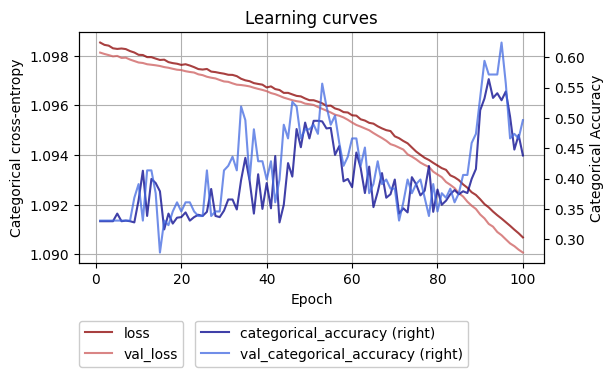

In [ ]:
# Architecture V1.1
cnn1_1 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1_1")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1_1.build(input_shape)
# Check network
cnn1_1.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.SGD(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 100
history1_1 = cnn1_1.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_1.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

We can see in the summary that the dimensions of the feature map change/decrease with every successive layer, and this model is very simple, with a total of 144,123 parameters. <br> After running the model through 100 epochs, the accuracy stays at most 55%, not steadily. The loss decreases very slowly.

### CNN1.2
We can improve the basic model by rescaling the data to the [0,1] range before we start the convolution process.

Model: "CNN-V1_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 18)      1368      
                                                                 
 activation_2 (Activation)   (None, 124, 124, 18)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 18)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 48)        21648     
                                                                 
 activation_3 (Activation)   (None, 58, 58, 48)        0         
                                                          

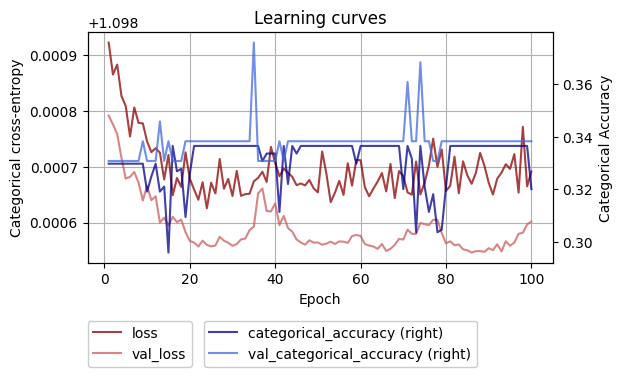

In [ ]:
# Architecture V1.2
cnn1_2 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), # subsampling
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1_2")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1_2.build(input_shape)
# Check network
cnn1_2.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_2.compile(loss="categorical_crossentropy",
             optimizer=optimizers.SGD(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V2)
epochs = 100
history1_2 = cnn1_2.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_2.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Adding rescaling does not improve the model, the accuracy dropped, and training or validation does not increase over 34%.

### CNN1.3
Therefore, we will add the augmentation we prepared previously. 

Model: "CNN-V1_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 124, 124, 18)      1368      
                                                                 
 activation_4 (Activation)   (None, 124, 124, 18)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 18)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 58, 58, 48)        216

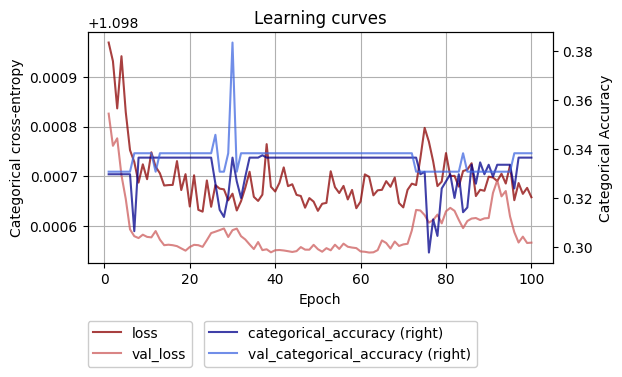

In [ ]:
# Architecture V1.3
cnn1_3 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                    # Data augmentation
                   augmentation, 
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), # subsampling
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1_3")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1_3.build(input_shape)
# Check network
cnn1_3.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_3.compile(loss="categorical_crossentropy",
             optimizer=optimizers.SGD(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V3)
epochs = 100
history1_3 = cnn1_3.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_3.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

tf.get_logger().setLevel('ERROR')

The results need to improve

### CNN1.4
Trying other optimizers, like AdaGrad, that adjust the learning rates of all model parameters individually by inversely scaling them with the square root of the sum of all historical squared gradient values. This method causes a more rapid decrease in the learning rate for parameters with the highest partial loss derivative. In contrast, those with smaller partial derivatives experience a relatively minor decrease in learning rate. As a result, the algorithm makes more significant progress in directions of parameter space with gentler slopes.

Model: "CNN-V1_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 124, 124, 18)      1368      
                                                                 
 activation_6 (Activation)   (None, 124, 124, 18)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 18)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 58, 58, 48)        216

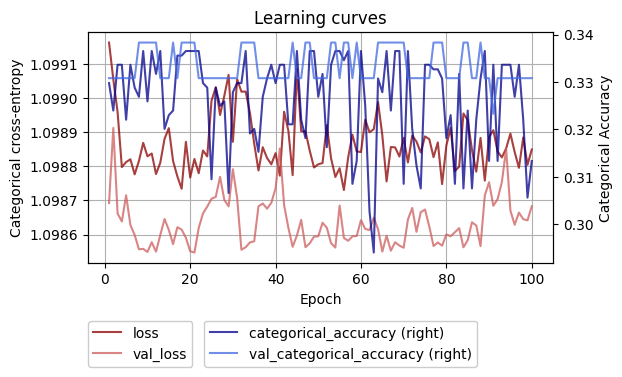

In [ ]:
# Architecture V1.4
cnn1_4 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Data augmentation
                   augmentation, 
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1_4")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1_4.build(input_shape)
# Check network
cnn1_4.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_4.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adagrad(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 100
history1_4 = cnn1_4.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_4.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN1.5
The RMSProp optimizer improves upon AdaGrad for nonconvex optimization problems using an exponentially weighted moving average instead of the original gradient accumulation method. While AdaGrad efficiently converges quickly when applied to convex functions, training a neural network with a nonconvex function may result in the learning trajectory passing through multiple structures before eventually reaching the minimum.

Model: "CNN-V1_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 124, 124, 18)      1368      
                                                                 
 activation_8 (Activation)   (None, 124, 124, 18)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 62, 62, 18)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 58, 58, 48)        216

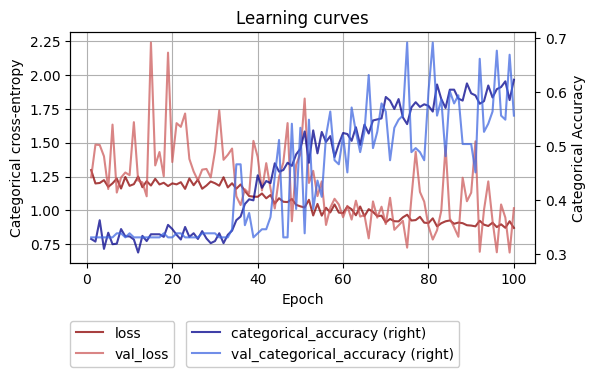

In [ ]:
# Architecture V1.5
cnn1_5 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Data augmentation
                   augmentation, 
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1_5")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1_5.build(input_shape)
# Check network
cnn1_5.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_5.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 100
history1_5 = cnn1_5.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_5.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

With this RMSProp optimizer, we start improving our results.

### CNN1.6
Changing to Adam optimizer. Adam, another adaptive learning rate optimization algorithm named for "adaptive moments". Adam can be considered a variant of the combination of RMSProp and momentum, but with several key differences. First, Adam directly incorporates momentum as an exponential-weighted estimate of the first-order moment of the gradient. In contrast, adding momentum to RMSProp is typically done to the rescaled gradients, needing a clear theoretical basis. Second, Adam includes bias corrections to account for the initialization of the first-order and uncentered second-order moments at the origin. While RMSProp also uses an uncentered second-order moment estimate, it does not correct for bias, leading to potentially high bias early in training. Finally, Adam is generally considered robust to hyperparameter choices, although the default learning rate may need adjustment.

Model: "CNN-V1.6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 rescaling_4 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 124, 124, 18)      1368      
                                                                 
 activation_10 (Activation)  (None, 124, 124, 18)      0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 62, 62, 18)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 58, 58, 48)        216

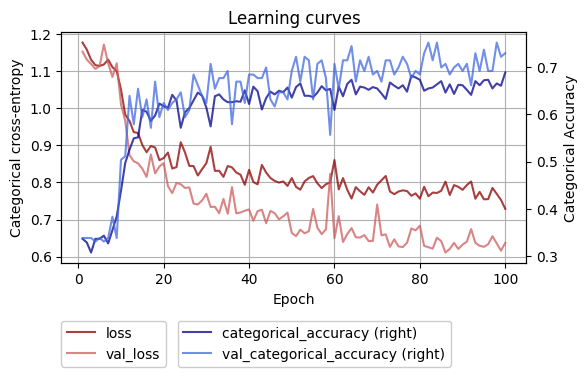

In [ ]:
# Architecture V1.6
cnn1_6 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Data augmentation
                   augmentation, 
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1.6")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1_6.build(input_shape)
# Check network
cnn1_6.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_6.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 100
history1_6 = cnn1_6.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_6.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

The model improves in the early epoch with the Adam optimizer and gets better accuracy than the previous optimizer.

### CNN1.7

Increasing the sample size of a batch can result in gradients that are more informative and less noisy. So we can try increase the batch size to 256.

Model: "CNN-V1.7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 rescaling_5 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 124, 124, 18)      1368      
                                                                 
 activation_12 (Activation)  (None, 124, 124, 18)      0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 62, 62, 18)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 58, 58, 48)        216

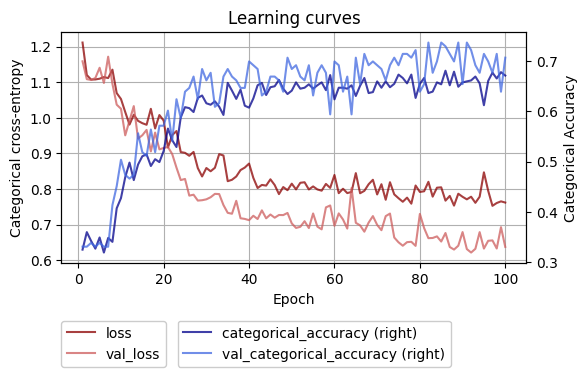

In [ ]:
# Architecture V1.7
cnn1_7 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Data augmentation
                   augmentation, 
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1.7")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1_7.build(input_shape)
# Check network
cnn1_7.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_7.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 100
history1_7 = cnn1_7.fit(ds_train, epochs=epochs, validation_data=ds_validation, batch_size=256)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_7.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN1.8

Increasing the learning rate

Model: "CNN-V1.8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 rescaling_6 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 124, 124, 18)      1368      
                                                                 
 activation_14 (Activation)  (None, 124, 124, 18)      0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 62, 62, 18)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 58, 58, 48)        216

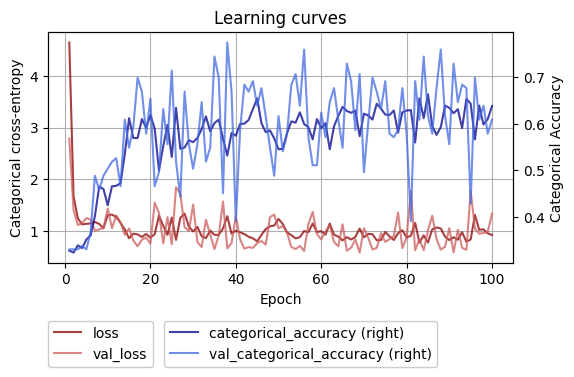

In [ ]:
# Architecture V1.8
cnn1_8 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Data augmentation
                   augmentation, 
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1.8")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1_8.build(input_shape)
# Check network
cnn1_8.summary()  

# Compiles the model for training.
learning_rate = 0.01 
cnn1_8.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 100
history1_8 = cnn1_8.fit(ds_train, epochs=epochs, validation_data=ds_validation, batch_size=256)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_8.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN1.9

Decreasing the learning rate

Model: "CNN-V1.9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 rescaling_7 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 124, 124, 18)      1368      
                                                                 
 activation_16 (Activation)  (None, 124, 124, 18)      0         
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 62, 62, 18)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 58, 58, 48)        216

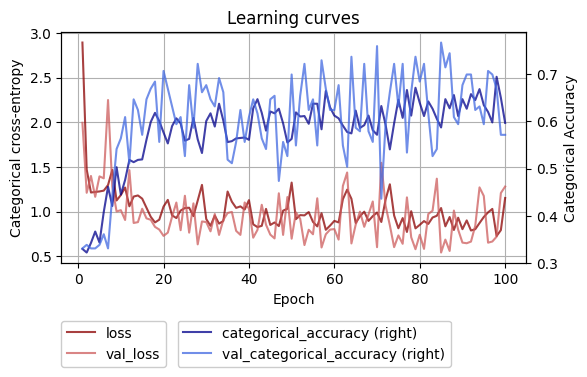

In [ ]:
# Architecture V1.9
cnn1_9 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Data augmentation
                   augmentation, 
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1.9")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1_9.build(input_shape)
# Check network
cnn1_9.summary()  

# Compiles the model for training.
learning_rate = 0.01 
cnn1_9.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 100
history1_9= cnn1_9.fit(ds_train, epochs=epochs, validation_data=ds_validation, batch_size=256)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_9.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Increasing the learning rate from 0.001 to 0.01 or decreasing it from 0.001 to 0.0001 does not improve the model. We will continue with 0.001.

### CNN 1.10

We are changing Rescaling to BatchNormalization, from the CNN1.6 version. Similar to rescaling, normalization sets all samples similar to each other. BatchNormalization normalizes data with z-score criteria, with a mean of 0 and a standard deviation of 1.

Model: "CNN-V1.10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d_18 (Conv2D)          (None, 124, 124, 18)      1368      
                                                                 
 activation_18 (Activation)  (None, 124, 124, 18)      0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 62, 62, 18)       0         
 g2D)                                                            
                                                         

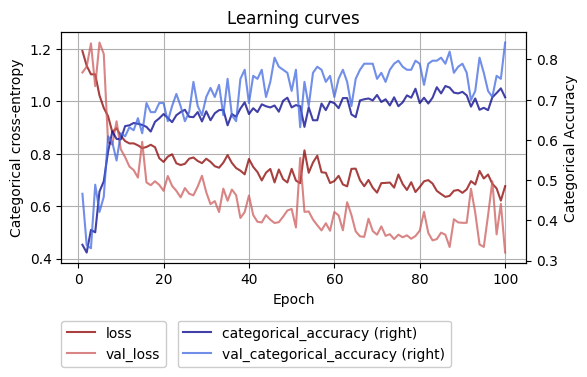

In [ ]:
# Architecture V1.10
cnn1_10 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Data augmentation
                   augmentation, 
                   # Data preprocessing
                   layers.BatchNormalization(),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1.10")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1_10.build(input_shape)
# Check network
cnn1_10.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_10.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 100
history1_10 = cnn1_10.fit(ds_train, epochs=epochs, validation_data=ds_validation, batch_size=256)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_10.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Version CNN1.10 seems to be the best so far for this LeNet Model: <br>
Batch size = 256, Learning Rate = 0.001, Adam Optimizer and BatchNormalization<br>
Nevertheless, this model underfits. We could add more epochs or change to a more complex model to overcome this.

### CNN 1.11

Before we move to a more complex model, we will check the behaviour of the model with different kernel size to (3,3).

Model: "CNN-V1.11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 18)      504       
                                                                 
 activation (Activation)     (None, 126, 126, 18)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 18)       0         
 )                                                               
                                                         

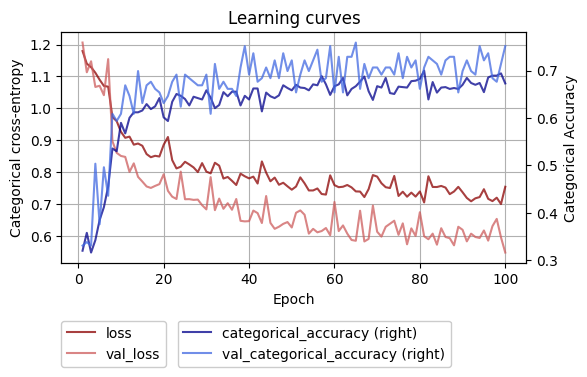

In [13]:
# Architecture V1.11
cnn1_11 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Data augmentation
                   augmentation, 
                   # Data preprocessing
                   layers.BatchNormalization(),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1.11")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1_11.build(input_shape)
# Check network
cnn1_11.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_11.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 100
history1_11 = cnn1_11.fit(ds_train, epochs=epochs, validation_data=ds_validation, batch_size=256)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_11.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Comparing kernel size from (5,5) to (3,3), We can see in the summary that the dimensions of the feature map increase, and the number of parameters decreases, so the results do not improve.

### +CNN 1.12

And kernel size to (7,7).

Model: "CNN-V1.12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 122, 122, 18)      2664      
                                                                 
 activation_2 (Activation)   (None, 122, 122, 18)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 61, 61, 18)       0         
 2D)                                                             
                                                         

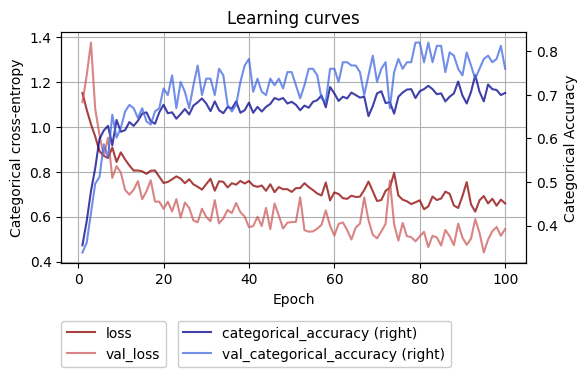

In [15]:
# Architecture V1.12
cnn1_12 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Data augmentation
                   augmentation, 
                   # Data preprocessing
                   layers.BatchNormalization(),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(7, 7),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(7, 7),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1.12")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1_12.build(input_shape)
# Check network
cnn1_12.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_12.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 100
history1_12 = cnn1_12.fit(ds_train, epochs=epochs, validation_data=ds_validation, batch_size=256)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_12.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Comparing kernel size from (5,5) to (7,7), We can see in the summary that the dimensions of the feature map decrease, and the number of parameters increases, and the results slightly improve.

With this exploration, we understood that batch size, Learning Rate, Optimizer, Normalization, and kernel size could be crucial to better performance in our model. This model is very simple. Next, we will move to a more complex model.

## CNN2 - AlexNet
We will approach the AlexNet method by adding the following:
* More layers (3 convolutional layers) <br>
* Replacing the softmax in the convolution with the Relu that breaks up the linearity to increase the non-linearity of the images <br>
* Employing the dropout rate regularization at the starting point of 20%  to avoid overfitting (as more complex  models start to overfit earlier) <br>
* Increase the kernel size in the firsts layers <br>
* Add max pooling and strides as a way to downsampling. Max pooling works better than other alternatives, like average pooling, because the features encode the spacial presence of some pattern or concept over the different tiles of the feature map. It is more informative. <br>
* Padding set as 'same' to get an output feature map with the same spatial dimension (width and height) as the input

###CNN2.1


We will keep augmentation and BatchNormalization at a starting point, as we already see it works fine. Furthermore, start exploring the best optimizer, starting with SGD.

Model: "CNN-V2.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_20 (Conv2D)          (None, 30, 30, 96)        34944     
                                                                 
 batch_normalization_2 (Batc  (None, 30, 30, 96)       384       
 hNormalization)                                                 
                                                                 
 activation_20 (Activation)  (None, 30, 30, 96)        0         
                                                          

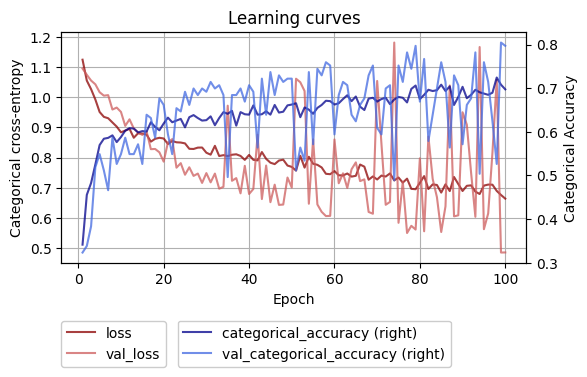

In [ ]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.2
# Architecture V2.1
cnn2_1 = Sequential([# The input layer
                   layers.Input(input_shape),
                   # Data augmentation
                   augmentation,     
                   # Feature extraction
                   layers.BatchNormalization(),
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P3
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V2.1")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn2_1.build(input_shape)
# Check network
cnn2_1.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn2_1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.SGD(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 100
history2_1 = cnn2_1.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2_1.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Here we are sharing more on the dimension of the images, and the number of parameters increases to 3,748,367.
With SGD optimizer, the model shows much instability.

### CNN2.2
As we got a volatile model, we will try the Adam optimizer, which works well in the LeNet Model.

Model: "CNN-V2_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 batch_normalization_3 (Batc  (None, 128, 128, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_25 (Conv2D)          (None, 30, 30, 96)        34944     
                                                                 
 batch_normalization_4 (Batc  (None, 30, 30, 96)       384       
 hNormalization)                                                 
                                                                 
 activation_25 (Activation)  (None, 30, 30, 96)        0         
                                                          

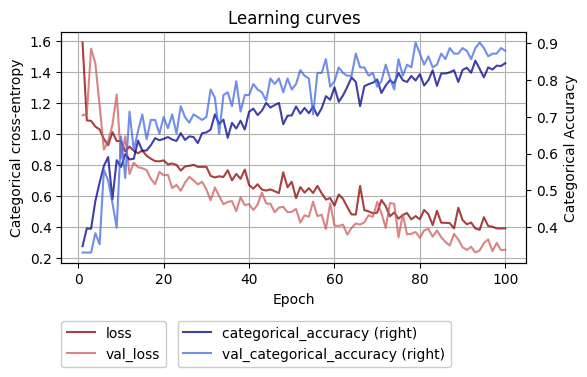

In [ ]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.2
# Architecture V2.2
cnn2_2 = Sequential([# The input layer
                   layers.Input(input_shape),
                   # Data augmentation
                   augmentation,      
                   # Feature extraction
                   layers.BatchNormalization(),
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P3
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V2_2")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn2_2.build(input_shape)
# Check network
cnn2_2.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn2_2.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 100
history2_2 = cnn2_2.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2_2.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Once again, Adam Optimized improved the model a lot.

### CNN2.3
We will try with RMSprop Optimizer

Model: "CNN-V2_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_30 (Conv2D)          (None, 30, 30, 96)        34944     
                                                                 
 batch_normalization_6 (Batc  (None, 30, 30, 96)       384       
 hNormalization)                                                 
                                                                 
 activation_30 (Activation)  (None, 30, 30, 96)        0         
                                                          

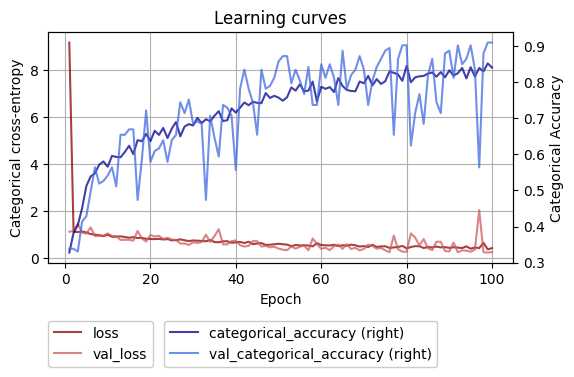

In [ ]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.2
# Architecture V2.3
cnn2_3 = Sequential([# The input layer
                   layers.Input(input_shape), 
                   # Data augmentation
                   augmentation,     
                   # Feature extraction
                   layers.BatchNormalization(),
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P3
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V2_3")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn2_3.build(input_shape)
# Check network
cnn2_3.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn2_3.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 100
history2_3 = cnn2_3.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2_3.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

RMSprop Optimizer seems less consistent.

### +CNN2.4
In the AlexNet method, the Adam Optimizer still works better. We will set dropout_rate = 0 and  increase the epoch to check until when the model starts to overfitting.

Model: "CNN-V2_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 batch_normalization_7 (Batc  (None, 128, 128, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_35 (Conv2D)          (None, 30, 30, 96)        34944     
                                                                 
 batch_normalization_8 (Batc  (None, 30, 30, 96)       384       
 hNormalization)                                                 
                                                                 
 activation_35 (Activation)  (None, 30, 30, 96)        0         
                                                          

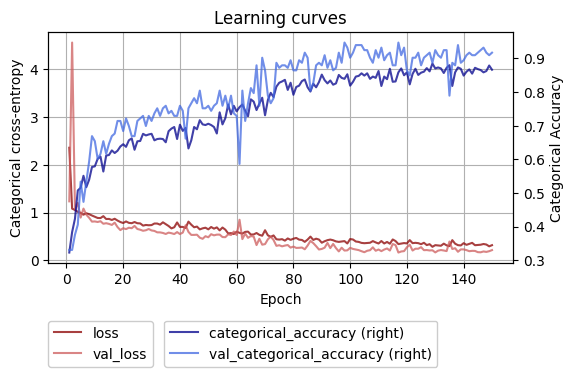

In [ ]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0
# Architecture V2.4
cnn2_4 = Sequential([# The input layer
                   layers.Input(input_shape),   
                   # Data augmentation
                   augmentation,   
                   # Feature extraction
                   layers.BatchNormalization(),
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P3
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V2_4")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn2_4.build(input_shape)
# Check network
cnn2_4.summary() 

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn2_4.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 150
history2_4 = cnn2_4.fit(ds_train, epochs=epochs, validation_data=ds_validation, batch_size = 256)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2_4.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

After about 100 epochs, the model starts to be much more steady.

### CNN2.5
And adding a drop out to 35%

Model: "CNN-V2_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 batch_normalization_9 (Batc  (None, 128, 128, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_40 (Conv2D)          (None, 30, 30, 96)        34944     
                                                                 
 batch_normalization_10 (Bat  (None, 30, 30, 96)       384       
 chNormalization)                                                
                                                                 
 activation_40 (Activation)  (None, 30, 30, 96)        0         
                                                          

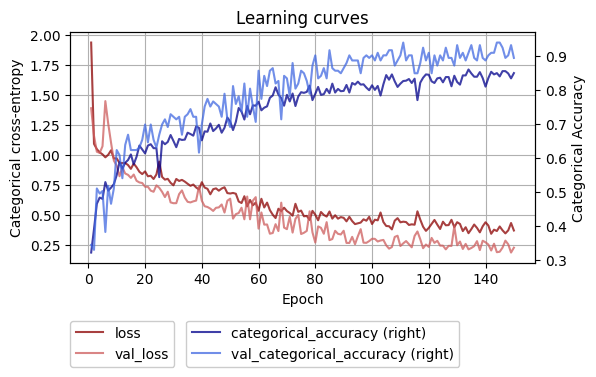

In [ ]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.35
# Architecture V2.5
cnn2_5 = Sequential([# The input layer
                   layers.Input(input_shape), 
                   # Data augmentation
                   augmentation,     
                   # Feature extraction
                   layers.BatchNormalization(),
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P3
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V2_5")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn2_5.build(input_shape)
# Check network
cnn2_5.summary() 

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn2_5.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 150
history2_5 = cnn2_5.fit(ds_train, epochs=epochs, validation_data=ds_validation, batch_size = 256)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2_5.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

We get excellent results with AlexNet, but it is still very unstable. We can try to simplify this model.

## CNN3 - AlexNet simplified
We will try an intermediate model, simpler then Alex, deleting the last block

### CNN3.1
without drop_out

Model: "CNN-V3_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 batch_normalization_2 (Batc  (None, 128, 128, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 96)        34944     
                                                                 
 batch_normalization_3 (Batc  (None, 30, 30, 96)       384       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 30, 30, 96)        0         
                                                          

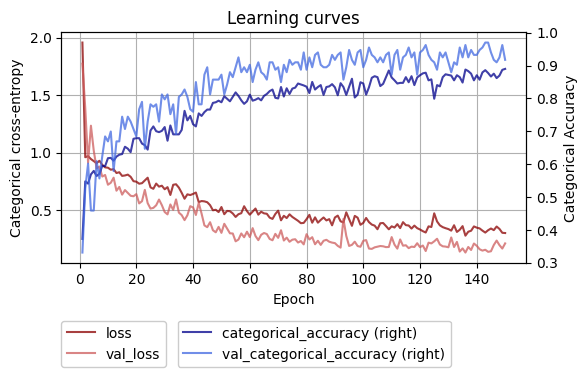

In [17]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0
# Architecture V3.1
cnn3_1 = Sequential([# The input layer
                   layers.Input(input_shape),  
                   # Data augmentation
                   augmentation,    
                   # Feature extraction
                   layers.BatchNormalization(),
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer = regularizers.L2(l2=1e-4),
                                bias_regularizer = regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V3_1")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn3_1.build(input_shape)
# Check network
cnn3_1.summary() 

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn3_1.build(input_shape)
# Check network
cnn3_1.summary() 

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn3_1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 150
history3_1 = cnn3_1.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history3_1.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### +CNN3.2
With a dropout rate of 35%

Model: "CNN-V3.2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 batch_normalization_4 (Batc  (None, 128, 128, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 30, 96)        34944     
                                                                 
 batch_normalization_5 (Batc  (None, 30, 30, 96)       384       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 30, 30, 96)        0         
                                                          

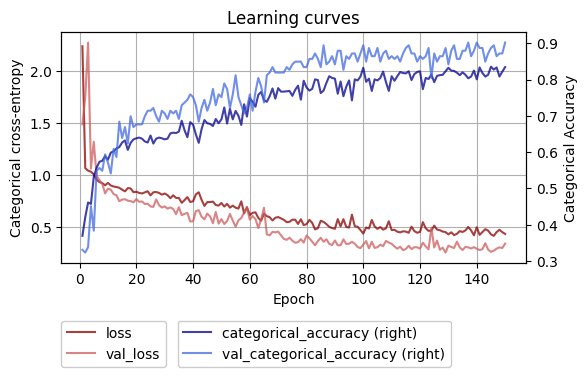

In [18]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.35
# Architecture V3.2
cnn3_2 = Sequential([# The input layer
                   layers.Input(input_shape), 
                   # Data augmentation
                   augmentation,     
                   # Feature extraction
                   layers.BatchNormalization(),  
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer = regularizers.L2(l2=1e-4),
                                bias_regularizer = regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V3.2")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn3_2.build(input_shape)
# Check network
cnn3_2.summary() 

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn3_2.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 150
history3_2 = cnn3_2.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history3_2.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN3.3
With RMSpro optimizer

Model: "CNN-V3.3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 batch_normalization_12 (Bat  (None, 128, 128, 3)      12        
 chNormalization)                                                
                                                                 
 conv2d_19 (Conv2D)          (None, 30, 30, 96)        34944     
                                                                 
 batch_normalization_13 (Bat  (None, 30, 30, 96)       384       
 chNormalization)                                                
                                                                 
 activation_19 (Activation)  (None, 30, 30, 96)        0         
                                                          

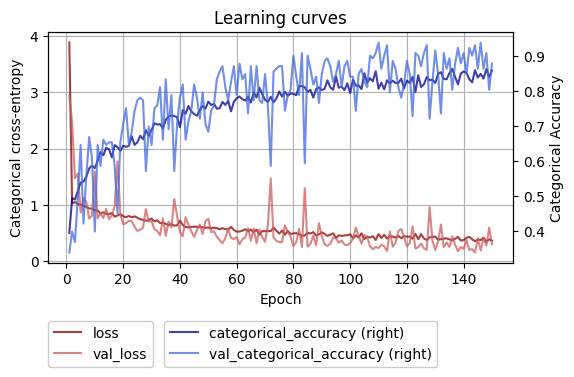

In [22]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.35
# Architecture V3.3
cnn3_3 = Sequential([# The input layer
                   layers.Input(input_shape), 
                   # Data augmentation
                   augmentation,     
                   # Feature extraction
                   layers.BatchNormalization(),  
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer = regularizers.L2(l2=1e-4),
                                bias_regularizer = regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V3.3")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn3_3.build(input_shape)
# Check network
cnn3_3.summary() 

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn3_3.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 150
history3_3 = cnn3_3.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history3_3.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In this version of Alex simplified, we get good results with Adam Optimized and it allows a better trade-off between performance and accuracy.

## VGG

In contrast to the prior model that utilized 11x11 and 5x5 kernels in the initial two convolutional layers, VGG incorporates a consecutive series of multiple 3x3 convolutional kernels. This enables a reduction in the number of trainable parameters, while retaining the receptive field and achieving superior generalization capability. The researchers determined that deep and slender CNNs surpass their shallow and broad counterparts by a significant margin. The basic concept behind the approach was to transition from a network design structured by individual layers to one structured by blocks, wherein each block is a series of multiple convolutional batch normalization and ReLU layers, culminating in a pooling layer.

In [ ]:
def block_vgg(conv_layers, filters, conv1x1=True, batch_norm=True, seed=0):
    block = Sequential()
    for l in range(conv_layers + conv1x1):
        block.add(layers.Conv2D(filters, 
                                kernel_size=1 if l==conv_layers else 3, padding="same",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)))
        if batch_norm:
            block.add(layers.BatchNormalization())                         
        block.add(layers.Activation("relu"))
    
    block.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    return block

### VGG1.1



VGG with three blocks and SGD optimizer with dropout rate of 20%

Model: "VGG-V1.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_17 (Bat  (64, 128, 128, 3)        12        
 chNormalization)                                                
                                                                 
 sequential (Sequential)     (64, 64, 64, 32)          10400     
                                                                 
 sequential_1 (Sequential)   (64, 32, 32, 64)          55936     
                                                                 
 sequential_2 (Sequential)   (64, 16, 16, 128)         239488    
                                                                 
 global_max_pooling2d (Globa  (64, 128)                0         
 lMaxPooling2D)                                                  
                                                                 
 dropout_8 (Dropout)         (64, 128)                 0  

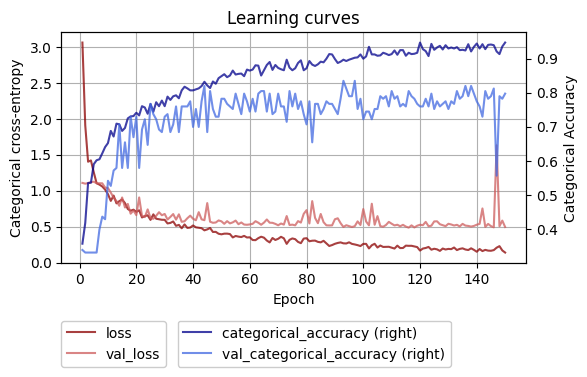

In [ ]:
# Extract the shape of one batch
input_shape = tuple(iter(ds_train).next()[0].shape)
# Define the architecture's blueprint 
vgg_blocks1_1 = ((2, 32, False), (2, 64, False), (2, 128, True)) 
# Create CNN
vgg1_1 = Sequential(layers.BatchNormalization(), name="VGG-V1.1")
# Add the convolutional backbone for learning representations
for conv_layers, filters, conv1x1 in vgg_blocks1_1:
    vgg1_1.add(block_vgg(conv_layers, filters, conv1x1, seed=seed))
# Define the classification head
vgg1_1.add(layers.GlobalMaxPooling2D())
vgg1_1.add(layers.Dropout(0.2))
vgg1_1.add(layers.Dense(units=3, activation="softmax",
                      kernel_initializer=initializers.GlorotNormal(seed=seed)))
# Build the DAG 
vgg1_1.build(input_shape)
# Check model
vgg1_1.summary()
# Define auxiliary constant for training (to use in the cells)
train = True

if train:
    # Measure the start time
    start = time.time()
    # 1. compiles the model
    learning_rate = 0.001
    vgg1_1.compile(loss="categorical_crossentropy",
                 optimizer=optimizers.SGD(learning_rate=learning_rate),  
                 metrics= [metrics.CategoricalAccuracy(name='categorical_accuracy'),
                          metrics.AUC(name='AUROC')])
    # 2. Trains the model
    epochs = 150
    history1_1 = vgg1_1.fit(ds_train, validation_data=ds_validation, epochs=epochs, verbose=2)
    # Measure the end time
    print("Training time: {:.4f}s".format(time.time() - start))
    # Do not train once this cell was executed 
    train = False
# 3. Creates a pandas.DataFrame from history dictionary
df_hist = pd.DataFrame.from_dict(history1_1.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

This is a simple version of VGG with 306,223 parameters <br>
After about 40 epochs, the model starts overfitting

### VGG1.2

With Adam optimizer

Model: "VGG-V1.2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_25 (Bat  (64, 128, 128, 3)        12        
 chNormalization)                                                
                                                                 
 sequential_3 (Sequential)   (64, 64, 64, 32)          10400     
                                                                 
 sequential_4 (Sequential)   (64, 32, 32, 64)          55936     
                                                                 
 sequential_5 (Sequential)   (64, 16, 16, 128)         239488    
                                                                 
 global_max_pooling2d_1 (Glo  (64, 128)                0         
 balMaxPooling2D)                                                
                                                                 
 dropout_9 (Dropout)         (64, 128)                 0  

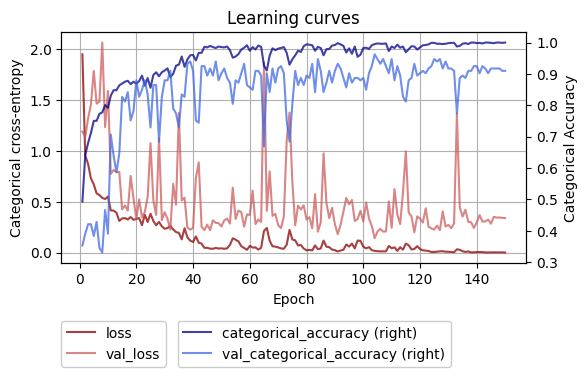

In [ ]:
# Extract the shape of one batch
input_shape = tuple(iter(ds_train).next()[0].shape)
# Define the architecture's blueprint 
vgg_blocks1_2 = ((2, 32, False), (2, 64, False), (2, 128, True)) 
# Create CNN
vgg1_2 = Sequential(layers.BatchNormalization(), name="VGG-V1.2")
# Add the convolutional backbone for learning representations
for conv_layers, filters, conv1x1 in vgg_blocks1_2:
    vgg1_2.add(block_vgg(conv_layers, filters, conv1x1, seed=seed))
# Define the classification head
vgg1_2.add(layers.GlobalMaxPooling2D())
vgg1_2.add(layers.Dropout(0.2))
vgg1_2.add(layers.Dense(units=3, activation="softmax",
                      kernel_initializer=initializers.GlorotNormal(seed=seed)))
# Build the DAG 
vgg1_2.build(input_shape)
# Check model
vgg1_2.summary()
# Define auxiliary constant for training (to use in the cells)
train = True

if train:
    # Measure the start time
    start = time.time()
    # 1. compiles the model
    learning_rate = 0.001
    vgg1_2.compile(loss="categorical_crossentropy",
                 optimizer=optimizers.Adam(learning_rate=learning_rate),  
                 metrics= [metrics.CategoricalAccuracy(name='categorical_accuracy'),
                          metrics.AUC(name='AUROC')])
    # 2. Trains the model
    epochs = 150
    history1_2 = vgg1_2.fit(ds_train, validation_data=ds_validation, epochs=epochs, verbose=2)
    # Measure the end time
    print("Training time: {:.4f}s".format(time.time() - start))
    # Do not train once this cell was executed 
    train = False
# 3. Creates a pandas.DataFrame from history dictionary
df_hist = pd.DataFrame.from_dict(history1_2.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### VGG1.3

With RMSprop optimizer

Model: "VGG-V1.3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_33 (Bat  (64, 128, 128, 3)        12        
 chNormalization)                                                
                                                                 
 sequential_6 (Sequential)   (64, 64, 64, 32)          10400     
                                                                 
 sequential_7 (Sequential)   (64, 32, 32, 64)          55936     
                                                                 
 sequential_8 (Sequential)   (64, 16, 16, 128)         239488    
                                                                 
 global_max_pooling2d_2 (Glo  (64, 128)                0         
 balMaxPooling2D)                                                
                                                                 
 dropout_10 (Dropout)        (64, 128)                 0  

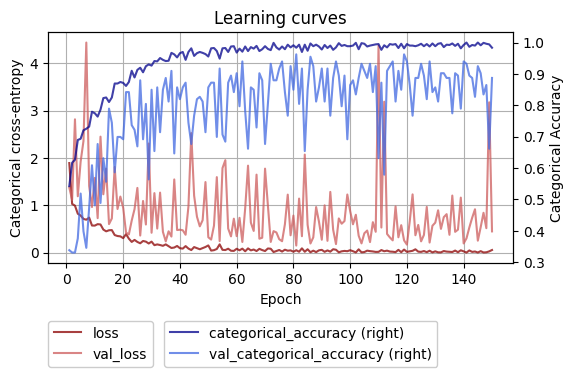

In [ ]:
# Extract the shape of one batch
input_shape = tuple(iter(ds_train).next()[0].shape)
# Define the architecture's blueprint 
vgg_blocks1_3 = ((2, 32, False), (2, 64, False), (2, 128, True)) 
# Create CNN
vgg1_3 = Sequential(layers.BatchNormalization(), name="VGG-V1.3")
# Add the convolutional backbone for learning representations
for conv_layers, filters, conv1x1 in vgg_blocks1_3:
    vgg1_3.add(block_vgg(conv_layers, filters, conv1x1, seed=seed))
# Define the classification head
vgg1_3.add(layers.GlobalMaxPooling2D())
vgg1_3.add(layers.Dropout(0.2))
vgg1_3.add(layers.Dense(units=3, activation="softmax",
                      kernel_initializer=initializers.GlorotNormal(seed=seed)))
# Build the DAG 
vgg1_3.build(input_shape)
# Check model
vgg1_3.summary()
# Define auxiliary constant for training (to use in the cells)
train = True

if train:
    # Measure the start time
    start = time.time()
    # 1. compiles the model
    learning_rate = 0.001
    vgg1_3.compile(loss="categorical_crossentropy",
                 optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
                 metrics= [metrics.CategoricalAccuracy(name='categorical_accuracy'),
                          metrics.AUC(name='AUROC')])
    # 2. Trains the model
    epochs = 150
    history1_3 = vgg1_3.fit(ds_train, validation_data=ds_validation, epochs=epochs, verbose=2)
    # Measure the end time
    print("Training time: {:.4f}s".format(time.time() - start))
    # Do not train once this cell was executed 
    train = False
# 3. Creates a pandas.DataFrame from history dictionary
df_hist = pd.DataFrame.from_dict(history1_3.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

For the VGG model, the SGD optimizer fits better, more stable.

### VGG1.4
Adding more feature detectors

Model: "VGG-V1.4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_41 (Bat  (64, 128, 128, 3)        12        
 chNormalization)                                                
                                                                 
 sequential_9 (Sequential)   (64, 64, 64, 64)          39232     
                                                                 
 sequential_10 (Sequential)  (64, 32, 32, 128)         222464    
                                                                 
 sequential_11 (Sequential)  (64, 16, 16, 256)         954112    
                                                                 
 global_max_pooling2d_3 (Glo  (64, 256)                0         
 balMaxPooling2D)                                                
                                                                 
 dropout_11 (Dropout)        (64, 256)                 0  

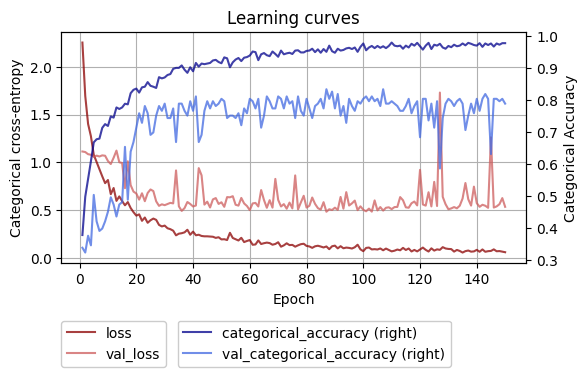

In [ ]:
# Extract the shape of one batch
input_shape = tuple(iter(ds_train).next()[0].shape)
# Define the architecture's blueprint 
vgg_blocks1_4 = ((2, 64, False), (2, 128, False), (2, 256, True)) 
# Create CNN
vgg1_4 = Sequential(layers.BatchNormalization(), name="VGG-V1.4")
# Add the convolutional backbone for learning representations
for conv_layers, filters, conv1x1 in vgg_blocks1_4:
    vgg1_4.add(block_vgg(conv_layers, filters, conv1x1, seed=seed))
# Define the classification head
vgg1_4.add(layers.GlobalMaxPooling2D())
vgg1_4.add(layers.Dropout(0.2))
vgg1_4.add(layers.Dense(units=3, activation="softmax",
                      kernel_initializer=initializers.GlorotNormal(seed=seed)))
# Build the DAG 
vgg1_4.build(input_shape)
# Check model
vgg1_4.summary()
# Define auxiliary constant for training (to use in the cells)
train = True

if train:
    # Measure the start time
    start = time.time()
    # 1. compiles the model
    learning_rate = 0.001
    vgg1_4.compile(loss="categorical_crossentropy",
                 optimizer=optimizers.SGD(learning_rate=learning_rate),  
                 metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                          metrics.AUC(name='AUROC')])
    # 2. Trains the model
    epochs = 150
    history1_4 = vgg1_4.fit(ds_train, validation_data=ds_validation, epochs=epochs, verbose=2)
    # Measure the end time
    print("Training time: {:.4f}s".format(time.time() - start))
    # Do not train once this cell was executed 
    train = False
# 3. Creates a pandas.DataFrame from history dictionary
df_hist = pd.DataFrame.from_dict(history1_4.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

After 25 epochs the model starts to overfitting. 

### VGG1.5
Increase the dropout rate to 40%

Model: "VGG-V1.5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_49 (Bat  (64, 128, 128, 3)        12        
 chNormalization)                                                
                                                                 
 sequential_12 (Sequential)  (64, 64, 64, 64)          39232     
                                                                 
 sequential_13 (Sequential)  (64, 32, 32, 128)         222464    
                                                                 
 sequential_14 (Sequential)  (64, 16, 16, 256)         954112    
                                                                 
 global_max_pooling2d_4 (Glo  (64, 256)                0         
 balMaxPooling2D)                                                
                                                                 
 dropout_12 (Dropout)        (64, 256)                 0  

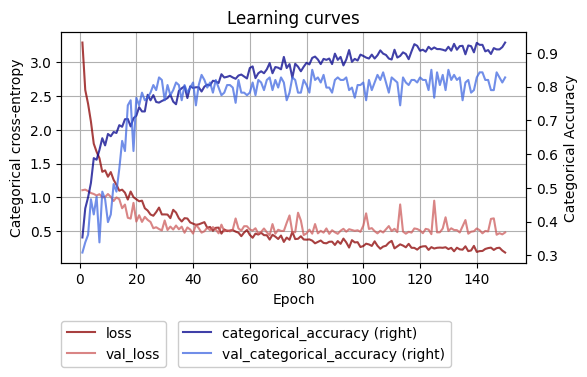

In [ ]:
# Extract the shape of one batch
input_shape = tuple(iter(ds_train).next()[0].shape)
# Define the architecture's blueprint 
vgg_blocks1_5 = ((2, 64, False), (2, 128, False), (2, 256, True)) 
# Create CNN
vgg1_5 = Sequential(layers.BatchNormalization(), name="VGG-V1.5")
# Add the convolutional backbone for learning representations
for conv_layers, filters, conv1x1 in vgg_blocks1_5:
    vgg1_5.add(block_vgg(conv_layers, filters, conv1x1, seed=seed))
# Define the classification head
vgg1_5.add(layers.GlobalMaxPooling2D())
vgg1_5.add(layers.Dropout(0.4))
vgg1_5.add(layers.Dense(units=3, activation="softmax",
                        kernel_regularizer=regularizers.L2(1e-5),
                        bias_regularizer=regularizers.L2(1e-4),
                        kernel_initializer=initializers.GlorotNormal(seed=seed)))
# Build the DAG 
vgg1_5.build(input_shape)
# Check model
vgg1_5.summary()
# Define auxiliary constant for training (to use in the cells)
train = True

if train:
    # Measure the start time
    start = time.time()
    # 1. compiles the model
    learning_rate = 0.001
    vgg1_5.compile(loss="categorical_crossentropy",
                 optimizer=optimizers.SGD(learning_rate=learning_rate),  
                 metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                          metrics.AUC(name='AUROC')])
    # 2. Trains the model
    epochs = 150
    history1_5 = vgg1_5.fit(ds_train, validation_data=ds_validation, epochs=epochs, verbose=2)
    # Measure the end time
    print("Training time: {:.4f}s".format(time.time() - start))
    # Do not train once this cell was executed 
    train = False
# 3. Creates a pandas.DataFrame from history dictionary
df_hist = pd.DataFrame.from_dict(history1_5.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### +VGG1.6
dropout rate of 50% and L2 regularization

Model: "VGG-V1.6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_82 (Bat  (64, 128, 128, 3)        12        
 chNormalization)                                                
                                                                 
 sequential_19 (Sequential)  (64, 64, 64, 64)          39232     
                                                                 
 sequential_20 (Sequential)  (64, 32, 32, 128)         222464    
                                                                 
 sequential_21 (Sequential)  (64, 16, 16, 256)         954112    
                                                                 
 global_max_pooling2d_9 (Glo  (64, 256)                0         
 balMaxPooling2D)                                                
                                                                 
 dropout_14 (Dropout)        (64, 256)                 0  

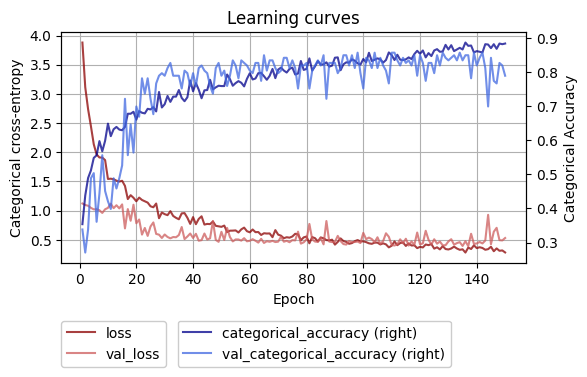

In [ ]:
# Extract the shape of one batch
input_shape = tuple(iter(ds_train).next()[0].shape)
# Define the architecture's blueprint 
vgg_blocks1_6 = ((2, 64, False), (2, 128, False), (2, 256, True))
vgg1_6 = Sequential(layers.BatchNormalization(), name="VGG-V1.6")
# Add the convolutional backbone for learning representations
for conv_layers, filters, conv1x1 in vgg_blocks1_6:
    vgg1_6.add(block_vgg(conv_layers, filters, conv1x1, seed=seed))
# Define the classification head
vgg1_6.add(layers.GlobalMaxPooling2D())
vgg1_6.add(layers.Dropout(0.5))
vgg1_6.add(layers.Dense(units=3, activation="softmax",
                        kernel_regularizer=regularizers.L2(1e-5),
                        bias_regularizer=regularizers.L2(1e-4),
                        kernel_initializer=initializers.GlorotNormal(seed=seed)))
# Build the DAG 
vgg1_6.build(input_shape)
# Check model
vgg1_6.summary()
# Define auxiliary constant for training (to use in the cells)
train = True

if train:
    # Measure the start time
    start = time.time()
    # 1. compiles the model
    learning_rate = 0.001
    vgg1_6.compile(loss="categorical_crossentropy",
                 optimizer=optimizers.SGD(learning_rate=learning_rate),  
                 metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                          metrics.AUC(name='AUROC')])
    # 2. Trains the model
    epochs = 150
    history1_6 = vgg1_6.fit(ds_train, validation_data=ds_validation, epochs=epochs, verbose=2)
    # Measure the end time
    print("Training time: {:.4f}s".format(time.time() - start))
    # Do not train once this cell was executed 
    train = False
# 3. Creates a pandas.DataFrame from history dictionary
df_hist = pd.DataFrame.from_dict(history1_6.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In VGG model, with SGD optimizer, With more feature detectors, with a dropout rate of 50% and adding L2 regularization we get more accuracy until about about 120 epochs whitout overfitting

## Functional API

Functional API provides more flexibility for designing complex and customized architectures. It allows to define multiple inputs and outputs and connect them in arbitrary ways. We can create branches or merge layers to create multiple paths in the network, which makes it possible to build more sophisticated architectures such as multi-input or multi-output models, recurrent neural networks, and models with shared layers.


### CNN4.1
Based on and inspired by what we explored previously, we will explore a new architecture three repeated groups of layers (blocks), use a progression  in the number of vconvolution filter 64, 128, and 256 with a relu activation function. We also add normalization in each block, normalization helps the model to learn and generalize, addng intermediate normalization, it can adaptively normalize data even as the mean and vaciance change over time during the training.

In [38]:
# 1. create an input node using the tf.keras.Input class (which is different from tf.keras.layers.Input). 
# The input node instantiates a symbolic tensor-like object that allows building a Keras model just by knowing the inputs and outputs of the model
inputs = layers.Input(shape=input_shape[1:])  
# 2. compute the z-scores from the batch
x = layers.BatchNormalization()(inputs)
# 3. specify the convolutional backbone for learning representations
x = layers.Conv2D(filters=64, kernel_size=3, 
                  kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
x = layers.BatchNormalization()(x) 
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, 
                  kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, 
                  kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
# 4. perform global pooling to reduce a HxWxC cuboid of features into a C-dimensional vector
x = layers.GlobalMaxPooling2D()(x)
# 5. specify the classifier
y_pred = layers.Dense(units=3, activation="softmax", 
                      kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
# 6. create final model from inputs and outputs using the tf.keras.Model class
cnn4_1 = Model(inputs, y_pred)
# Check network
cnn4_1.summary()  # alternatively use tf.keras.utils.plot_model(cnn1, show_shapes=True)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 batch_normalization_23 (Bat  (None, 128, 128, 3)      12        
 chNormalization)                                                
                                                                 
 conv2d_29 (Conv2D)          (None, 126, 126, 64)      1792      
                                                                 
 batch_normalization_24 (Bat  (None, 126, 126, 64)     256       
 chNormalization)                                                
                                                                 
 activation_27 (Activation)  (None, 126, 126, 64)      0         
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 63, 63, 64)       0   

We end up with a new dimensions size of the feature map with a model with 373,391 parameters

Epoch 1/150
17/17 [==============================] - 7s 158ms/step - loss: 1.2564 - categorical_accuracy: 0.4284 - AUROC: 0.6009 - val_loss: 1.3185 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5470
Epoch 2/150
17/17 [==============================] - 2s 101ms/step - loss: 0.8875 - categorical_accuracy: 0.6074 - AUROC: 0.7809 - val_loss: 1.1265 - val_categorical_accuracy: 0.3534 - val_AUROC: 0.5687
Epoch 3/150
17/17 [==============================] - 2s 102ms/step - loss: 0.7626 - categorical_accuracy: 0.6934 - AUROC: 0.8424 - val_loss: 1.0583 - val_categorical_accuracy: 0.4737 - val_AUROC: 0.6332
Epoch 4/150
17/17 [==============================] - 2s 104ms/step - loss: 0.6688 - categorical_accuracy: 0.7311 - AUROC: 0.8831 - val_loss: 1.0326 - val_categorical_accuracy: 0.5038 - val_AUROC: 0.6673
Epoch 5/150
17/17 [==============================] - 3s 114ms/step - loss: 0.6109 - categorical_accuracy: 0.7718 - AUROC: 0.9049 - val_loss: 1.0230 - val_categorical_accuracy: 0.4361 - val

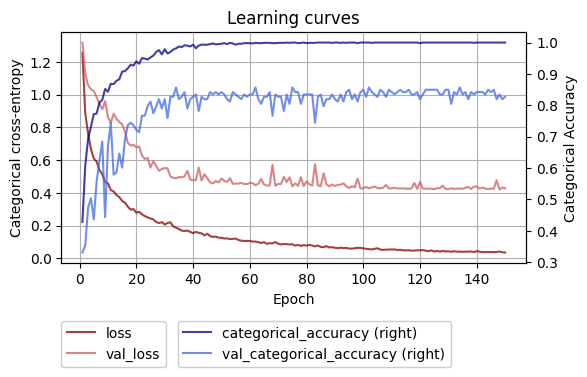

In [39]:
# Compiles the model for training.
learning_rate = 0.001  
cnn4_1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.SGD(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 150
history4_1 = cnn4_1.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history4_1.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In this version the model does not generalize.

### CNN4.2
So we will check with RMSprop optimizer

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 batch_normalization_27 (Bat  (None, 128, 128, 3)      12        
 chNormalization)                                                
                                                                 
 conv2d_32 (Conv2D)          (None, 126, 126, 64)      1792      
                                                                 
 batch_normalization_28 (Bat  (None, 126, 126, 64)     256       
 chNormalization)                                                
                                                                 
 activation_30 (Activation)  (None, 126, 126, 64)      0         
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 63, 63, 64)       0   

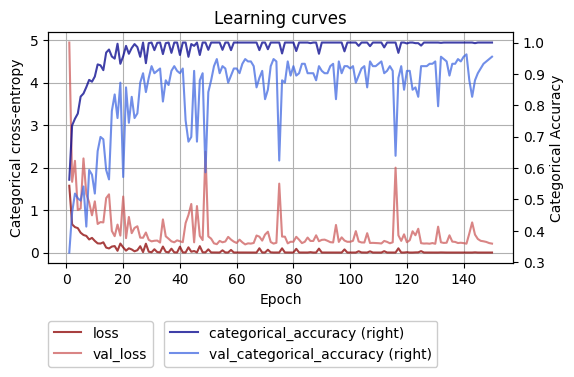

In [40]:
# 1. create an input node using the tf.keras.Input class (which is different from tf.keras.layers.Input). 
# The input node instantiates a symbolic tensor-like object that allows building a Keras model just by knowing the inputs and outputs of the model
inputs = layers.Input(shape=input_shape[1:])  
# 2. compute the z-scores from the batch
x = layers.BatchNormalization()(inputs)
# 3. specify the convolutional backbone for learning representations
x = layers.Conv2D(filters=64, kernel_size=3, 
                  kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
x = layers.BatchNormalization()(x) 
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, 
                  kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, 
                  kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
# 4. perform global pooling to reduce a HxWxC cuboid of features into a C-dimensional vector
x = layers.GlobalMaxPooling2D()(x)
# 5. specify the classifier
y_pred = layers.Dense(units=3, activation="softmax", 
                      kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
# 6. create final model from inputs and outputs using the tf.keras.Model class
cnn4_2 = Model(inputs, y_pred)
# Check network
cnn4_2.summary()  # alternatively use tf.keras.utils.plot_model(cnn1, show_shapes=True)

# Compiles the model for training.
learning_rate = 0.001  
cnn4_2.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 150
history4_2 = cnn4_2.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history4_2.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

The results are more instable

### CNN4.3
 With Adam optimizer

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 batch_normalization_31 (Bat  (None, 128, 128, 3)      12        
 chNormalization)                                                
                                                                 
 conv2d_35 (Conv2D)          (None, 126, 126, 64)      1792      
                                                                 
 batch_normalization_32 (Bat  (None, 126, 126, 64)     256       
 chNormalization)                                                
                                                                 
 activation_33 (Activation)  (None, 126, 126, 64)      0         
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 63, 63, 64)       0   

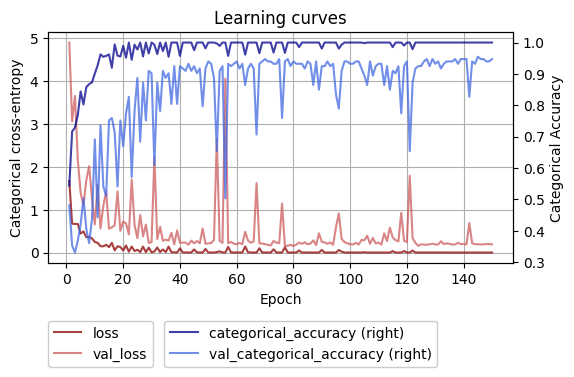

In [41]:
# 1. create an input node using the tf.keras.Input class (which is different from tf.keras.layers.Input). 
# The input node instantiates a symbolic tensor-like object that allows building a Keras model just by knowing the inputs and outputs of the model
inputs = layers.Input(shape=input_shape[1:])  
# 2. compute the z-scores from the batch
x = layers.BatchNormalization()(inputs)
# 3. specify the convolutional backbone for learning representations
x = layers.Conv2D(filters=64, kernel_size=3, 
                  kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
x = layers.BatchNormalization()(x) 
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, 
                  kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, 
                  kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
# 4. perform global pooling to reduce a HxWxC cuboid of features into a C-dimensional vector
x = layers.GlobalMaxPooling2D()(x)
# 5. specify the classifier
y_pred = layers.Dense(units=3, activation="softmax", 
                      kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
# 6. create final model from inputs and outputs using the tf.keras.Model class
cnn4_3 = Model(inputs, y_pred)
# Check network
cnn4_3.summary()  # alternatively use tf.keras.utils.plot_model(cnn1, show_shapes=True)

# Compiles the model for training.
learning_rate = 0.001  
cnn4_3.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 150
history4_3 = cnn4_3.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history4_3.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

It also does not improve

### +CNN4.4
 With SGD optimizer, augmentation and a dropout rate of 30%

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 batch_normalization_1 (Batc  (None, 126, 126, 64)     256       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 126, 126, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0     

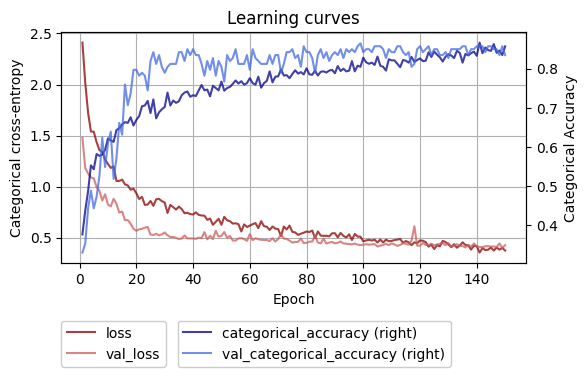

In [11]:
# 1. create an input node using the tf.keras.Input class (which is different from tf.keras.layers.Input). 
# The input node instantiates a symbolic tensor-like object that allows building a Keras model just by knowing the inputs and outputs of the model
inputs = layers.Input(shape=input_shape[1:])  
x = augmentation(inputs)
# 2. compute the z-scores from the batch
x = layers.BatchNormalization()(inputs)
# 3. specify the convolutional backbone for learning representations
x = layers.Conv2D(filters=64, kernel_size=3, 
                  kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
x = layers.BatchNormalization()(x) 
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, 
                  kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, 
                  kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
# 4. perform global pooling to reduce a HxWxC cuboid of features into a C-dimensional vector
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dropout(0.3)(x)
# 5. specify the classifier
y_pred = layers.Dense(units=3, activation="softmax", 
                      kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
# 6. create final model from inputs and outputs using the tf.keras.Model class
cnn4_3 = Model(inputs, y_pred)
# Check network
cnn4_3.summary()  # alternatively use tf.keras.utils.plot_model(cnn1, show_shapes=True)

# Compiles the model for training.
learning_rate = 0.001  
cnn4_3.compile(loss="categorical_crossentropy",
             optimizer=optimizers.SGD(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 150
history4_3 = cnn4_3.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history4_3.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

With these parameters, the training and validation accuracy strat to converged.

###  ResNet

With an approach very similiar to the previous one, we will add residual connections, by adding the input of the block of layers back to its output. The residual connections act as a information shortcup  around noise blocks in a deep network, which can consist of relu activations or dropout layers. By doing so, these connections allow the error gradient information from the initial layers to travel smoothly and without distortion through the network.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 128, 128, 3)  12         ['input_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 conv2d_4 (Conv2D)              (None, 126, 126, 64  1792        ['batch_normalization_4[0][0]']  
                                )                                                             

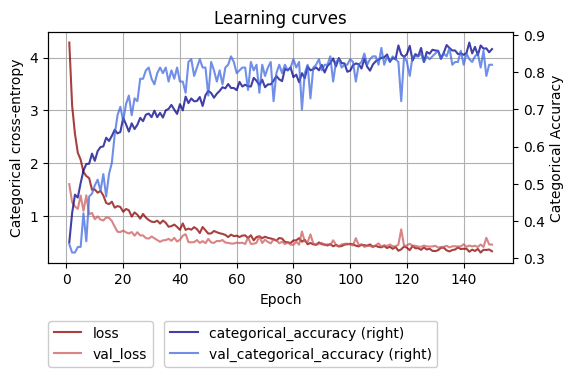

In [12]:
# 1. create an input node using the tf.keras.Input class (which is different from tf.keras.layers.Input). 
# The input node instantiates a symbolic tensor-like object that allows building a Keras model just by knowing the inputs and outputs of the model
inputs = layers.Input(shape=input_shape[1:])  
x = augmentation(inputs)
# 2. compute the z-scores from the batch
x = layers.BatchNormalization()(inputs)
# 3. specify the convolutional backbone for learning representations
x = layers.Conv2D(filters=64, kernel_size=3, 
                  kernel_initializer=initializers.GlorotNormal(seed=seed))(x)

for size in [64, 128]:   #, 128, 256, 512
# Save a ointer to the original input. The residual 
  residual = x

# Blocks of layers that can be potentially noisy 
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.MaxPooling2D(pool_size=1)(x)
  x = layers.Conv2D(size, 3, padding="same", use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.MaxPooling2D(pool_size=1)(x)
  x = layers.Conv2D(size, 3, padding="same", use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
  residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)

# Add the original input to the layer's output: the final output will always preserve full information about original input
  x = layers.add([x, residual])


# 4. perform global pooling to reduce a HxWxC cuboid of features into a C-dimensional vector
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dropout(0.3)(x)
# 5. specify the classifier
y_pred = layers.Dense(units=3, activation="softmax", 
                      kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
# 6. create final model from inputs and outputs using the tf.keras.Model class
resnet1_1 = Model(inputs, y_pred)
# Check network
resnet1_1.summary()  # alternatively use tf.keras.utils.plot_model(cnn1, show_shapes=True)

# Compiles the model for training.
learning_rate = 0.001  
resnet1_1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.SGD(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 150
history1_1 = resnet1_1.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_1.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

# Outcomes

We explored six main architectures. The first and the simplest was inspired by the LeNet work, and AlexNet inspired the second, the next one was kind of AlexNet simplified, followed by VGG, a custom model, and at the end, the ResNet. In each architecture, we explore different approaches, different numbers of layers, different kernel sizes, with and without augmentation, with and without normalization, and different normalization, layers with and without normalization. With the suitable parameters, we managed to get good results for each of one architecture. We use many epochs because our first goal was to find the best parameters to give enough power to the model and then regularize it. Finding the best optimizer and the correct way to regularize to model was crucial to find good results. Generally, we got a good accuracy in every model, around 80% in categorical and validation accuracy. We also decreased the loss function and validation loss function by around 0.4. Below is a summary of the best result for each architecture at the same epoch number, 100 and 150.

For 100 epochs

|Model             | Version | Optimizer | Dropout Rate | Epochs | categorical_accuracy | val_categorical_accuracy | loss | val_loss  |
|:---------------|:-----:|:-----:|:----:| :----:|:----:|:----:|:----:|:----:|
|LeNet              | CNN1.12 | Adam | 0% | 100 | 70.41% | 75.94% | 0.6591 | 0.5445 |
|AlexNet             | CNN2.4 | Adam | 0% | 100 | 81.91% | 90.23% | 0.4467 | 0.263 |
|AlexNet Simplified  | CNN3.2 | Adam | 35% | 100 | 83.27% | 89.47% | 0.4388 | 0.3325 |
| VGG                | VGG1.6 | SGD | 50% | 100 | 83.85% | 75.19% | 0.4755 | 0.6202 |
| Custom             | CNN4.4 | SGD | 30% | 100 | 82.79% | 84.21% | 0.4636 | 0.4303 |
| ResNet             | ResNet1.1 | SGD | 30% | 100 | 81.62% | 84.96% | 0.4447 | 0.4473 |

For 150 epochs

|Model             | Version | Optimizer | Dropout Rate | Epochs | categorical_accuracy | val_categorical_accuracy | loss | val_loss  |
|:---------------|:-----:|:-----:|:----:| :----:|:----:|:----:|:----:|:----:|
|AlexNet             | CNN2.4 | Adam | 0% | 150 | 86.65% | 91.73% | 0.3189 | 0.2158 |
|AlexNet Simplified  | CNN3.2 | Adam | 35% | 150 | 83.46% | 90.23% | 0.4348 | 0.3425 |
| VGG                | VGG1.6 | SGD | 50% | 150 | 88.39% | 78.95% | 0.2846 | 0.5321 |
| Custom             | CNN4.4 | SGD | 30% | 150 | 85.69% | 83.46% | 0.3732 | 0.4251 |
| ResNet             | ResNet1.1 | SGD | 30% | 150 | 88.1% | 84.96% | 0.3179 | 0.4296 |




